#ASSIGNMENT 10 - FIRST PART

In [0]:
from keras import backend as K
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from vis.utils import utils
from vis.visualization import visualize_saliency, overlay, visualize_cam, visualize_activation

from keras import activations
from keras.preprocessing import image
import numpy as np
import cv2
from skimage import io
import matplotlib.cm as cm

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
#Loading the pretrained weights of VGG for Imagenet
model = VGG16(weights="imagenet", include_top=True)

W0701 13:01:41.583157 140351507953536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0701 13:01:41.609180 140351507953536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0701 13:01:41.614310 140351507953536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0701 13:01:41.645628 140351507953536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0701 13:01:44.384496 140351507953536 deprecation_wrapp

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
#Function to plot original and GradCAM images
def plotOrigGradcam(test_image, layer):
  x = image.img_to_array(test_image)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  print(class_idx)
  class_output = model.output[:, class_idx]

  grads = K.gradients(class_output, layer.output)[0]
  print(grads.shape)
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  print(pooled_grads.shape)
  iterate = K.function([model.input], [pooled_grads, layer.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
  heatmap = np.mean(conv_layer_output_value, axis = -1)
  print(conv_layer_output_value.shape)
  print(heatmap.shape)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  
  heatmap = cv2.resize(heatmap, (test_image.shape[1], test_image.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(test_image, 0.5, heatmap, 0.5, 0)
  from google.colab.patches import cv2_imshow
  cv2_imshow(test_image)
  cv2_imshow(superimposed_img)

In [0]:
#Different layers to be tested on
Rohan_layer = model.get_layer("block5_conv3")
Rohan_layer_before = model.get_layer("block5_conv2")
Rohan_layer_before_before = model.get_layer("block5_conv1")

#GradCAM for a ship image for Rohan's layer

628
(?, 14, 14, 512)
(512,)
(14, 14, 512)
(14, 14)


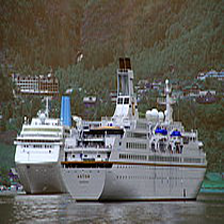

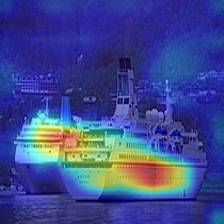

In [7]:
ship = io.imread('/content/gdrive/My Drive/ship.jpg')
ship = cv2.resize(ship, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)

plotOrigGradcam(ship, Rohan_layer)

#GradCAM for a ship image for Rohan's previous layer

628
(?, 14, 14, 512)
(512,)
(14, 14, 512)
(14, 14)


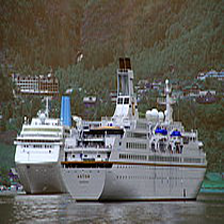

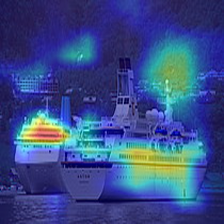

In [8]:
plotOrigGradcam(ship, Rohan_layer_before)

#GradCAM for a ship image for Rohan's previous' previous layer

628
(?, 14, 14, 512)
(512,)
(14, 14, 512)
(14, 14)


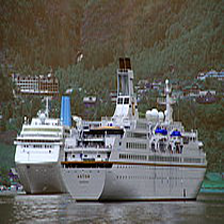

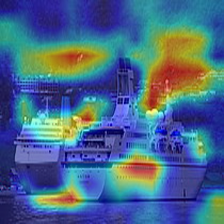

In [9]:
plotOrigGradcam(ship, Rohan_layer_before_before)

**628 class is 'liner, ocean liner' in Imagenet dataset.**

#GradCAM for Iron Man image for Rohan's layer

837
(?, 14, 14, 512)
(512,)
(14, 14, 512)
(14, 14)


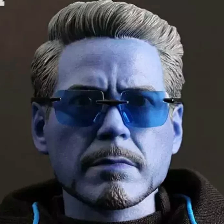

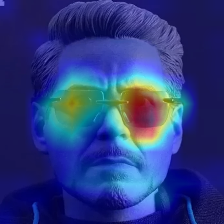

In [10]:
iron_man = io.imread('/content/gdrive/My Drive/IronMan.jpg')
iron_man = cv2.resize(iron_man, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)

plotOrigGradcam(iron_man, Rohan_layer)

#GradCAM for Iron Man image for Rohan's previous layer

837
(?, 14, 14, 512)
(512,)
(14, 14, 512)
(14, 14)


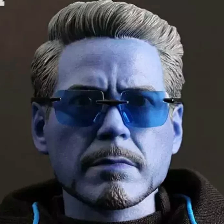

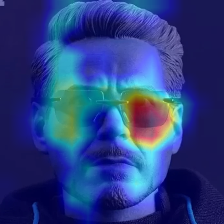

In [11]:
plotOrigGradcam(iron_man, Rohan_layer_before)

#GradCAM for Iron Man image for Rohan's previous' previous layer

837
(?, 14, 14, 512)
(512,)
(14, 14, 512)
(14, 14)


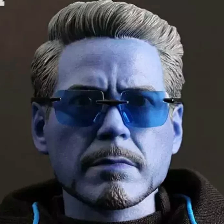

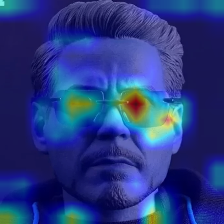

In [12]:
plotOrigGradcam(iron_man, Rohan_layer_before_before)

**837 class is 'sunglasses, dark glasses, shades'.**

**To visualize activation over final dense layer outputs, we need to switch the softmax activation out for linear since gradient of output node will depend on all the other node activations.**

In [37]:
# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'predictions')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [0]:
#pip install git+git://github.com/raghakot/keras-vis.git --upgrade --no-deps

#Original Image

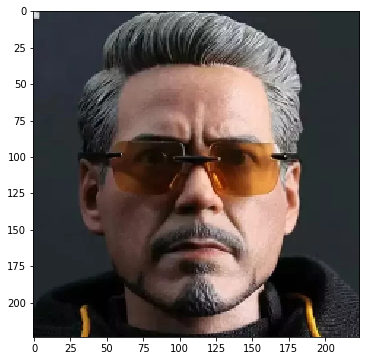

In [25]:
from vis.utils import utils
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

iron_man = io.imread('/content/gdrive/My Drive/IronMan.jpg')
iron_man = cv2.resize(iron_man, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)

plt.imshow(iron_man)

#Saliency visualization

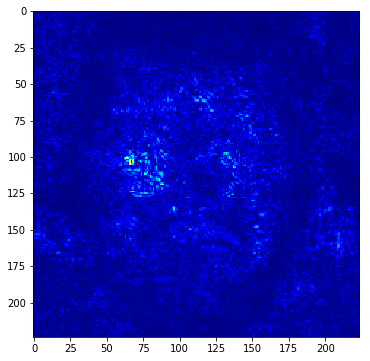

In [26]:
# 837 is the imagenet index corresponding to `sunglasses`
grads = visualize_saliency(model, layer_idx, filter_indices=837, seed_input=iron_man)
    
# visualize grads as heatmap
plt.imshow(grads, cmap='jet')

#Guided and Rectified saliency visualization

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


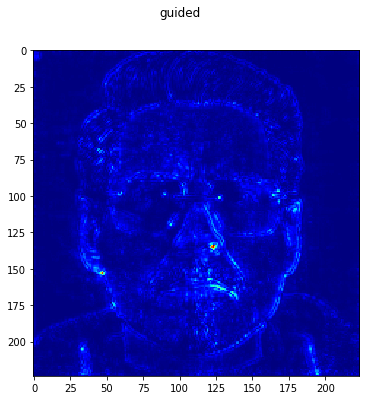

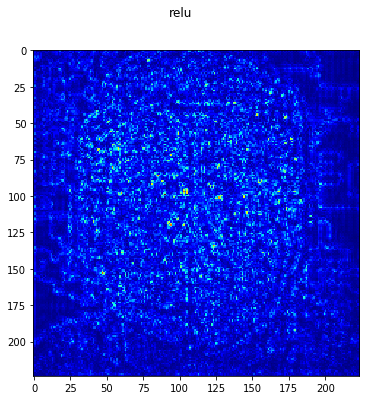

In [28]:
for modifier in ['guided', 'relu']:
    plt.figure()
    plt.suptitle(modifier)

    grads = visualize_saliency(model, layer_idx, filter_indices=837, 
                                   seed_input=iron_man, backprop_modifier=modifier)
    
    # Lets overlay the heatmap onto original image.    
    plt.imshow(grads, cmap='jet')

#GradCAM - Vanilla, Guided and Rectified

These should contain more detail since they use Conv or Pooling features that contain more spatial detail which is lost in Dense layers.

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


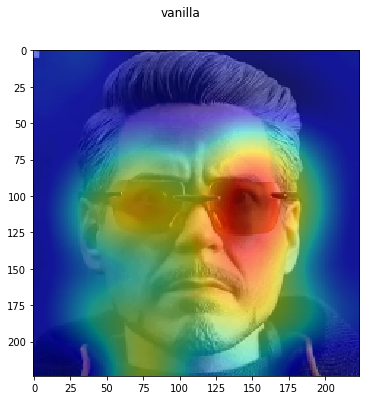

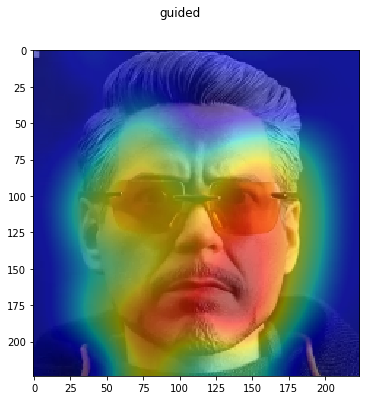

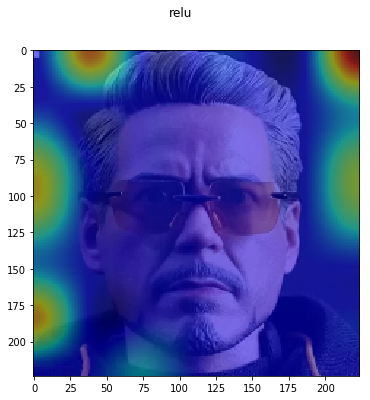

In [38]:
for modifier in [None, 'guided', 'relu']:
    plt.figure()

    plt.suptitle("vanilla" if modifier is None else modifier)
   
    # 837 is the imagenet index corresponding to `sunglasses`
    grads = visualize_cam(model, layer_idx, filter_indices=837, 
                              seed_input=iron_man, backprop_modifier=modifier)        
    
    # Lets overlay the heatmap onto original image.    
    jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)

    plt.imshow(overlay(jet_heatmap, iron_man))

#Visualizing a specific output category

W0701 13:25:45.415574 140351507953536 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


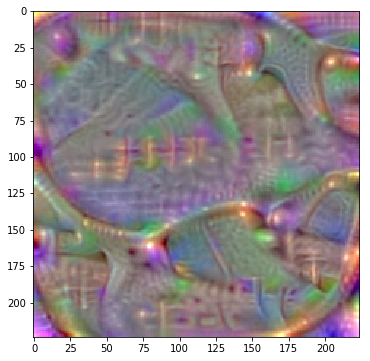

In [32]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

# 837 is the imagenet category for 'sunglasses'
img = visualize_activation(model, layer_idx, filter_indices=837)
plt.imshow(img)

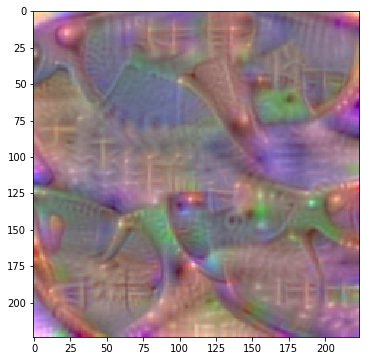

In [33]:
# 837 is the imagenet category for 'sunglasses'
img = visualize_activation(model, layer_idx, filter_indices=837, max_iter=500, verbose=False)
plt.imshow(img)

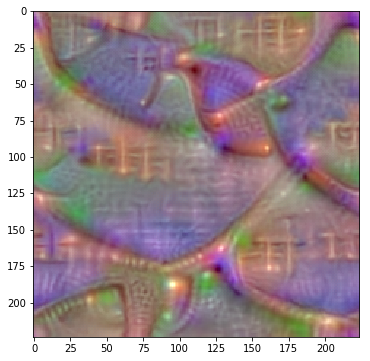

In [34]:
from vis.input_modifiers import Jitter

# 837 is the imagenet category for 'sunglasses'
# Jitter 16 pixels along all dimensions to during the optimization process.
img = visualize_activation(model, layer_idx, filter_indices=837, max_iter=500, input_modifiers=[Jitter(16)])
plt.imshow(img)

#ASSIGNMENT 10 - SECOND PART

# Given table

![alt text](https://github.com/SomaKorada07/EIP/blob/master/RF_Calculation.PNG?raw=true)

#SOLUTION

![alt text](https://github.com/SomaKorada07/EIP/blob/master/Assignment10B.jpg?raw=true)